<a href="https://colab.research.google.com/github/gaojing33/Stat-Data-Science/blob/main/data_peocess_by_Jing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Univariate regression of gdp per capita on garbage per capita**

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Step 1: Load the GDP data
gdp_path = '/content/GDP per capita.csv'
gdp_df = pd.read_csv(gdp_path)

# Calculate the average GDP per country and list the included years
gdp_year_columns = [col for col in gdp_df.columns if col != 'Country']
gdp_df[gdp_year_columns] = gdp_df[gdp_year_columns].apply(pd.to_numeric, errors='coerce')
gdp_df['GDP Average'] = gdp_df[gdp_year_columns].mean(axis=1)
gdp_df['Included Years'] = gdp_df[gdp_year_columns].apply(lambda row: ', '.join(row.dropna().index), axis=1)

# Keep only necessary columns for the merged output
gdp_processed = gdp_df[['Country', 'GDP Average', 'Included Years']]

# Step 2: Load the Waste data using a different encoding to handle the Unicode error
waste_path = '/content/waste_per_capita.csv'
waste_df = pd.read_csv(waste_path, encoding='ISO-8859-1')

# Calculate the average Waste per capita and list the included years, ignoring spaces
waste_year_columns = [col for col in waste_df.columns if col != 'Country']
waste_df[waste_year_columns] = waste_df[waste_year_columns].apply(pd.to_numeric, errors='coerce')
waste_df['Waste Average'] = waste_df[waste_year_columns].mean(axis=1)
waste_df['Included Years Waste'] = waste_df[waste_year_columns].apply(lambda row: ', '.join(row.dropna().index), axis=1)

# Keep only necessary columns for the merged output
waste_processed = waste_df[['Country', 'Waste Average', 'Included Years Waste']]

# Step 3: Merge GDP and Waste data on 'Country'
merged_df = pd.merge(gdp_processed, waste_processed, on='Country', how='outer')

# Convert all columns to string type before filling missing values
merged_df = merged_df.astype(str)
merged_df.fillna('/', inplace=True)

# Step 4: Load the Taxes data
taxes_path = '/content/TAXES_Var_European_Countries.csv'
taxes_df = pd.read_csv(taxes_path, encoding='ISO-8859-1')

# Step 5: Merge Taxes data with the already merged GDP and Waste data
final_df = pd.merge(merged_df, taxes_df, on='Country', how='outer')

# Convert all columns to string type before filling missing values
final_df = final_df.astype(str)
final_df.fillna('/', inplace=True)

# Display the final dataframe
final_df.head()

# Optionally, save the final processed dataframe to a CSV file
final_df.to_csv('/content/Final_Merged_Data.csv', index=False)


In [12]:
final_df.to_csv('/content/Final_Merged_Data.csv', index=False)
from google.colab import files

files.download('/content/Final_Merged_Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Import Plotly for interactive plotting
import plotly.express as px

# Create an interactive scatter plot with Plotly, using hover_name to display country info on hover only
fig = px.scatter(
    filtered_df,
    x='GDP Average',
    y='Waste Average',
    hover_name='Country',  # Use country names to show on hover
    labels={'GDP Average': 'GDP Average', 'Waste Average': 'Waste Average'},
    title='Interactive Relationship between Waste Average and GDP Average'
)

# Add the regression line to the plot using Plotly's trendline option
fig.update_traces(marker=dict(size=10, color='blue', line=dict(width=2, color='DarkSlateGrey')))

# Add trendline for linear regression
fig.add_scatter(
    x=filtered_df['GDP Average'],
    y=slope * filtered_df['GDP Average'] + intercept,
    mode='lines',
    line=dict(color='red'),
    name=f'Fit Line: y = {slope:.4f}x + {intercept:.4f}'
)

# Show the interactive plot
fig.show()



In [20]:
from scipy.stats import linregress

# Perform linear regression using scipy to get detailed statistics
regression_results = linregress(filtered_df['GDP Average'], filtered_df['Waste Average'])

# Extract regression statistics
slope = regression_results.slope
intercept = regression_results.intercept
r_value = regression_results.rvalue
p_value = regression_results.pvalue
std_err = regression_results.stderr

# Display regression statistics
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


Slope: 2.470002098015767e-06
Intercept: 0.3340650028163279
R-squared: 0.18716560296185783
P-value: 0.016950469964423138
Standard Error: 9.727613894895917e-07


# **Univariate regressions after adding the severity of environmental protection policies**

In [36]:
import plotly.express as px
import pandas as pd

# Ensure 'GDP Average', 'Waste Average', and 'Strictness_1.4_50' columns are numeric
final_df['GDP Average'] = pd.to_numeric(final_df['GDP Average'], errors='coerce')
final_df['Waste Average'] = pd.to_numeric(final_df['Waste Average'], errors='coerce')
final_df['Strictness_1.4_50'] = pd.to_numeric(final_df['Strictness_1.4_50'], errors='coerce')

# Filter out rows with missing or infinite values to ensure data quality
final_df = final_df.dropna(subset=['GDP Average', 'Waste Average'])

# Add a new column to categorize countries by policy strictness
final_df['Policy Category'] = final_df['Strictness_1.4_50'].apply(
    lambda x: 'Strict Policy (1)' if x == 1 else ('Lenient Policy (0)' if x == 0 else 'No Strictness Data'))

# Create the interactive scatter plot using Plotly with built-in trendline functionality for strict and lenient countries
fig = px.scatter(final_df,
                 x='GDP Average',
                 y='Waste Average',
                 color='Policy Category',
                 hover_name='Country',  # This will display the country name when hovering over the points
                 labels={'GDP Average': 'GDP Average', 'Waste Average': 'Waste Average'},
                 title='Interactive Relationship between Waste Average and GDP Average by Policy Strictness')

# Add trendlines manually for strict and lenient countries using Plotly's line traces
# Regression for strict policy countries
strict_countries = final_df[final_df['Policy Category'] == 'Strict Policy (1)']
if len(strict_countries) > 1:
    strict_fit = px.scatter(strict_countries, x='GDP Average', y='Waste Average', trendline='ols').data[1]
    strict_fit['line']['color'] = 'blue'
    strict_fit['name'] = 'Strict Policy Trendline'
    fig.add_trace(strict_fit)

# Regression for lenient policy countries
lenient_countries = final_df[final_df['Policy Category'] == 'Lenient Policy (0)']
if len(lenient_countries) > 1:
    lenient_fit = px.scatter(lenient_countries, x='GDP Average', y='Waste Average', trendline='ols').data[1]
    lenient_fit['line']['color'] = 'green'
    lenient_fit['name'] = 'Lenient Policy Trendline'
    fig.add_trace(lenient_fit)

# Update layout for better visualization
fig.update_layout(legend_title_text='Policy Strictness',
                  xaxis_title='GDP Average',
                  yaxis_title='Waste Average')

# Show the interactive plot
fig.show()


In [37]:
import statsmodels.api as sm

# Function to perform linear regression and display results
def perform_regression_analysis(data, group_name):
    X = sm.add_constant(data['GDP Average'])  # Add a constant (intercept) to the model
    model = sm.OLS(data['Waste Average'], X).fit()  # Fit the model
    regression_summary = {
        'Category': group_name,
        'Slope': model.params['GDP Average'],
        'Intercept': model.params['const'],
        'R-squared': model.rsquared,
        'P-value': model.pvalues['GDP Average'],
        'Standard Error': model.bse['GDP Average']
    }
    return regression_summary

# Perform regression for strict countries (Strictness_1.4_50 == 1)
strict_regression_results = perform_regression_analysis(strict_countries, 'Strict Policy (1)')

# Perform regression for lenient countries (Strictness_1.4_50 == 0)
lenient_regression_results = perform_regression_analysis(lenient_countries, 'Lenient Policy (0)')

# Combine the results into a DataFrame for easy display
regression_summary_df = pd.DataFrame([strict_regression_results, lenient_regression_results])

# Display the regression summary table
print(regression_summary_df)


             Category         Slope  Intercept  R-squared   P-value  \
0   Strict Policy (1)  4.276150e-06   0.288209   0.580534  0.027997   
1  Lenient Policy (0)  5.967440e-07   0.400924   0.028568  0.640651   

   Standard Error  
0        0.000001  
1        0.000001  


### Regression Analysis Summary

Based on the results of the regression analysis for countries with different levels of policy strictness, here is the interpretation:

#### 1. Strict Policy Countries (Strict Policy (1))
- **Slope**: \( 4.276 \times 10^{-6} \)
  - The slope indicates that for each unit increase in GDP, the Waste average increases by approximately \( 4.276 \times 10^{-6} \) units. Although this value is small, it suggests a more significant impact of GDP on Waste in strict policy countries compared to other policy types.
- **Intercept**: 0.288209
  - The intercept represents the predicted Waste value when GDP is zero. While having a zero GDP is unrealistic, this value is mainly used for the calculation of the regression equation.
- **R-squared**: 0.580534
  - This value shows that the model explains about 58.05% of the variation in Waste, indicating a strong explanatory power of the linear relationship between GDP and Waste in strict policy countries.
- **P-value**: 0.027997
  - A P-value below 0.05 indicates that the relationship between GDP and Waste is statistically significant in strict policy countries, suggesting that GDP has a meaningful impact on Waste in these nations.
- **Standard Error**: \( 1 \times 10^{-6} \)
  - The relatively small standard error indicates a stable estimate of the slope, giving the regression model a high level of confidence.

#### 2. Lenient Policy Countries (Lenient Policy (0))
- **Slope**: \( 5.967 \times 10^{-7} \)
  - In lenient policy countries, each unit increase in GDP results in only about \( 5.967 \times 10^{-7} \) units increase in Waste, suggesting a very weak impact of GDP on Waste in these nations.
- **Intercept**: 0.400924
  - This intercept value indicates the predicted Waste level when GDP is zero, which is used to form the regression equation.
- **R-squared**: 0.028568
  - The very low R-squared value of 2.86% indicates that GDP has almost no explanatory power on Waste in lenient policy countries, suggesting that other factors are likely influencing Waste generation.
- **P-value**: 0.640651
  - The high P-value above 0.05 indicates that the relationship between GDP and Waste is not statistically significant in lenient policy countries, implying that GDP and Waste have no meaningful linear correlation in these nations.
- **Standard Error**: \( 1 \times 10^{-6} \)
  - The standard error is similar to that of strict policy countries, but the near-zero slope makes the error range relatively more significant.

### Summary
- **Strict Policy Countries**: In these countries, the relationship between GDP and Waste has a relatively high explanatory power (R-squared value) and is statistically significant (P-value < 0.05). This suggests that economic growth (GDP) significantly affects Waste production in nations with strict environmental policies.
  
- **Lenient Policy Countries**: In lenient policy countries, the impact of GDP on Waste is extremely weak (very low slope) and statistically insignificant (high P-value). This indicates that GDP is not a major factor in determining Waste production in these countries.

- **Impact of Policy Strictness**: These findings suggest that the level of policy strictness plays a role in influencing the correlation between GDP and Waste. In countries with strict environmental policies, GDP has a more significant impact on Waste production, possibly due to more effective waste management and regulation efforts.

To gain a higher explanatory power in further analysis, it would be beneficial to include additional variables (e.g., waste management regulations, recycling rates, industrial composition) to build a multivariate regression model for a more comprehensive understanding of Waste generation factors.


# **Descriptive statistical analysis**

Descriptive Statistics for Waste:
count    30.000000
mean      0.419686
std       0.139092
min       0.230934
25%       0.357643
50%       0.403562
75%       0.460027
max       1.010798
Name: Waste Average, dtype: float64

Descriptive Statistics for GDP:
count        30.000000
mean      34664.520063
std       24362.264357
min        4924.952700
25%       15694.402400
50%       26975.286000
75%       47398.728050
max      111148.397800
Name: GDP Average, dtype: float64

Descriptive Statistics for Taxes:
count    18.000000
mean      1.465138
std       0.468846
min       0.875000
25%       1.067935
50%       1.286371
75%       1.817621
max       2.293478
Name: Value, dtype: float64


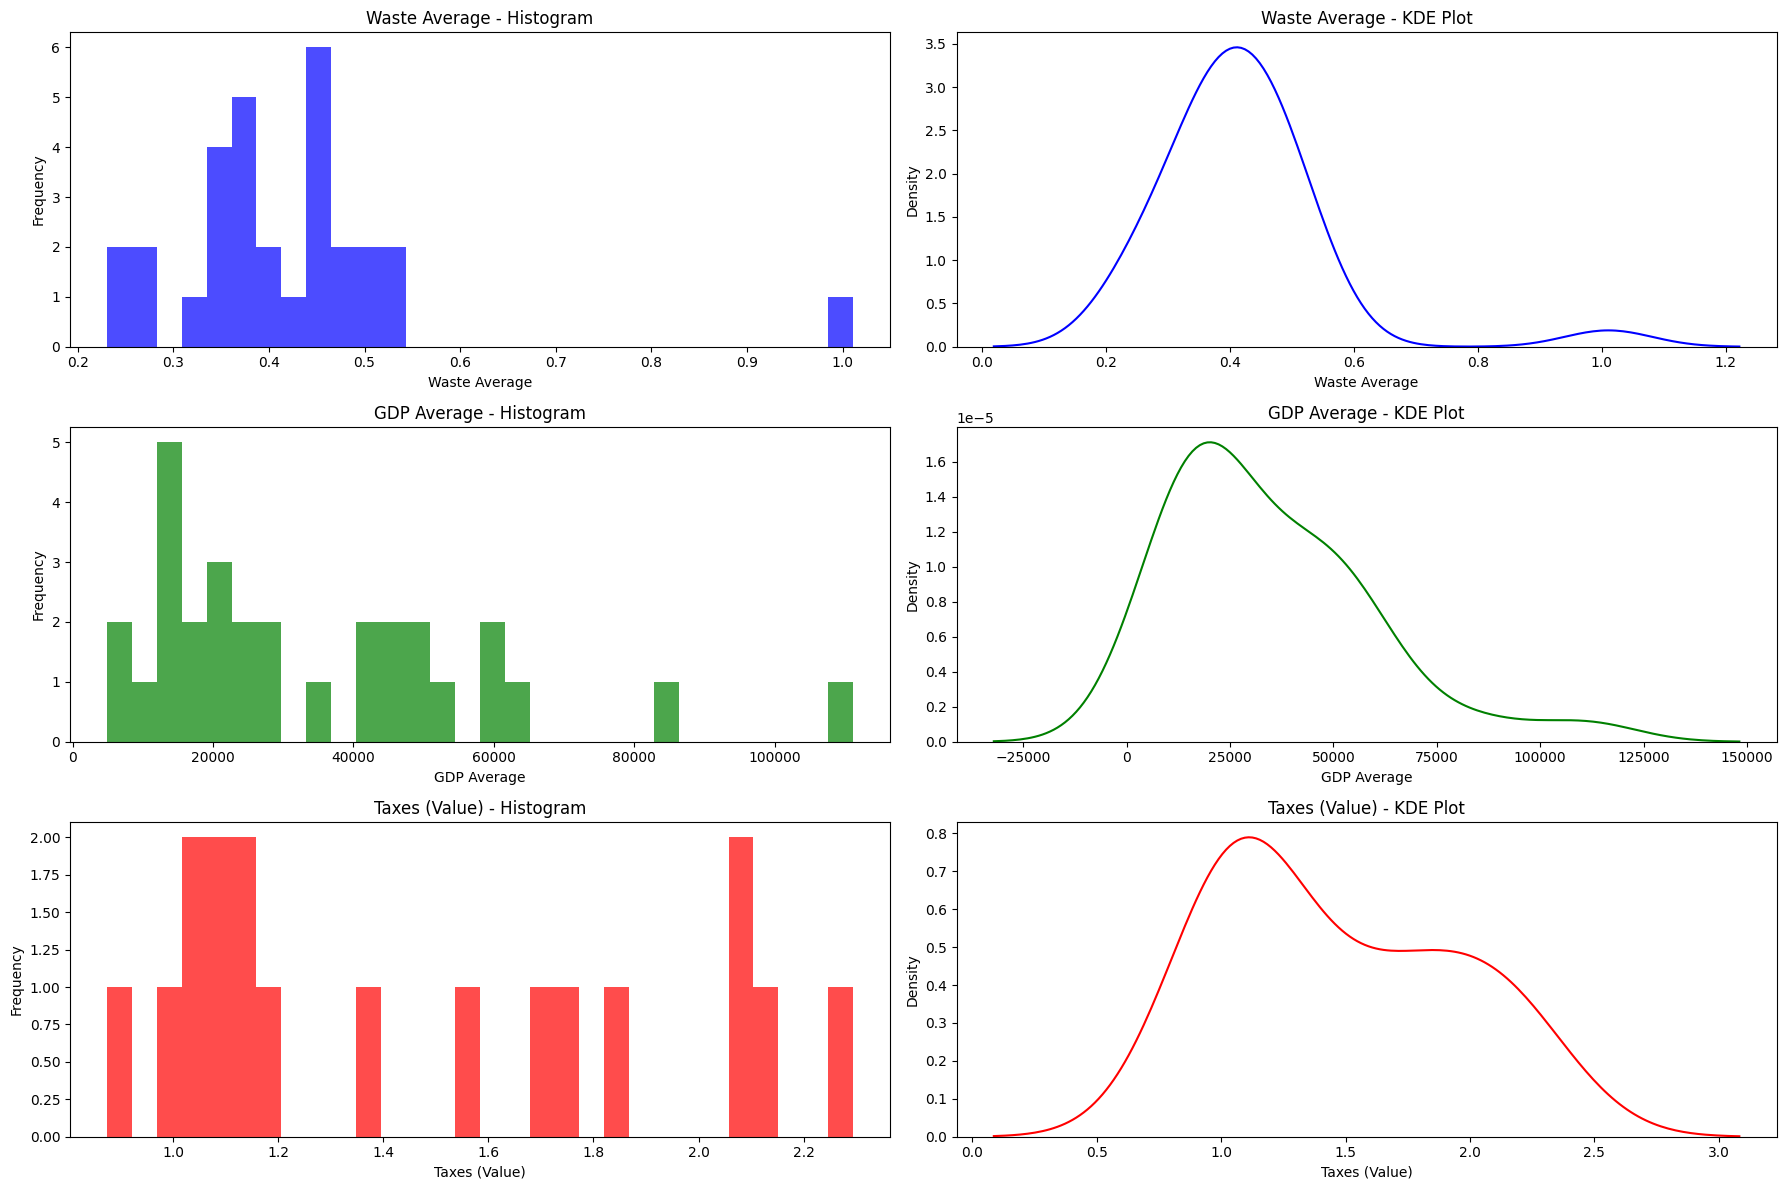

In [42]:
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'GDP Average', 'Waste Average', and 'Value' (representing Taxes) columns are numeric
final_df['GDP Average'] = pd.to_numeric(final_df['GDP Average'], errors='coerce')
final_df['Waste Average'] = pd.to_numeric(final_df['Waste Average'], errors='coerce')
final_df['Value'] = pd.to_numeric(final_df['Value'], errors='coerce')

# Step 1: Descriptive Statistics for Waste, GDP, and Taxes
waste_stats = final_df['Waste Average'].describe()
gdp_stats = final_df['GDP Average'].describe()
taxes_stats = final_df['Value'].describe()

print("Descriptive Statistics for Waste:")
print(waste_stats)
print("\nDescriptive Statistics for GDP:")
print(gdp_stats)
print("\nDescriptive Statistics for Taxes:")
print(taxes_stats)

# Step 2: Create box plots with jittered points for Waste, GDP, and Taxes using Plotly

# Waste Average - Combined Box Plot and Scatter Plot
fig_waste = px.box(final_df, y='Waste Average', points='all', hover_name='Country',
                   title='Waste Average Distribution with Jittered Points',
                   labels={'Waste Average': 'Waste Average'},
                   template='plotly_white')

# GDP Average - Combined Box Plot and Scatter Plot
fig_gdp = px.box(final_df, y='GDP Average', points='all', hover_name='Country',
                 title='GDP Average Distribution with Jittered Points',
                 labels={'GDP Average': 'GDP Average'},
                 template='plotly_white')

# Taxes (Value) - Combined Box Plot and Scatter Plot
fig_taxes = px.box(final_df, y='Value', points='all', hover_name='Country',
                   title='Taxes (Value) Distribution with Jittered Points',
                   labels={'Value': 'Taxes (Value)'},
                   template='plotly_white')

# Step 3: Create histogram and KDE plots for Waste, GDP, and Taxes using Matplotlib and Seaborn

plt.figure(figsize=(18, 12))

# Waste Average Histogram and KDE
plt.subplot(3, 2, 1)
plt.hist(final_df['Waste Average'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Waste Average - Histogram')
plt.xlabel('Waste Average')
plt.ylabel('Frequency')

plt.subplot(3, 2, 2)
sns.kdeplot(final_df['Waste Average'].dropna(), color='blue')
plt.title('Waste Average - KDE Plot')
plt.xlabel('Waste Average')
plt.ylabel('Density')

# GDP Average Histogram and KDE
plt.subplot(3, 2, 3)
plt.hist(final_df['GDP Average'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('GDP Average - Histogram')
plt.xlabel('GDP Average')
plt.ylabel('Frequency')

plt.subplot(3, 2, 4)
sns.kdeplot(final_df['GDP Average'].dropna(), color='green')
plt.title('GDP Average - KDE Plot')
plt.xlabel('GDP Average')
plt.ylabel('Density')

# Taxes (Value) Histogram and KDE
plt.subplot(3, 2, 5)
plt.hist(final_df['Value'].dropna(), bins=30, color='red', alpha=0.7)
plt.title('Taxes (Value) - Histogram')
plt.xlabel('Taxes (Value)')
plt.ylabel('Frequency')

plt.subplot(3, 2, 6)
sns.kdeplot(final_df['Value'].dropna(), color='red')
plt.title('Taxes (Value) - KDE Plot')
plt.xlabel('Taxes (Value)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Step 4: Display the Plotly interactive plots
fig_waste.show()
fig_gdp.show()
fig_taxes.show()
